In [1]:
import re
import os
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from contractions import contractions_dict

In [2]:
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [3]:
# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [4]:
# Set the base directory
base_dir = "data/BBCNewsSummary/News Articles"
output_dir = "data/BBCNewsSummaryCSV"  # Output directory

# Check if the output directory exists, and create it if not
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the list of classes (subfolder names)
classes = os.listdir(base_dir)
dfs = {}
# Create dataframes and write to CSV files for each class
for class_name in classes:
    # Define the paths for news articles and summaries
    news_articles_path = os.path.join(base_dir, class_name)
    summaries_path = os.path.join("data/BBCNewsSummary/Summaries", class_name)

    # Get the list of file names in both directories
    news_articles_files = os.listdir(news_articles_path)
    summaries_files = os.listdir(summaries_path)

    # Match file names
    common_files = set(news_articles_files) & set(summaries_files)

    # Create dataframe
    df_list = []

    # Read content from files and populate dataframe
    for filename in sorted(common_files):  # Sort by filename
        news_article_file_path = os.path.join(news_articles_path, filename)
        summary_file_path = os.path.join(summaries_path, filename)

        # Detect encoding
        news_encoding = detect_encoding(news_article_file_path)
        summary_encoding = detect_encoding(summary_file_path)

        try:
            with open(news_article_file_path, 'r', encoding=news_encoding) as news_file, \
                    open(summary_file_path, 'r', encoding=summary_encoding) as summary_file:
                news_content = news_file.read()
                summary_content = summary_file.read()
                

                # Extract file name without extension
                file_name_without_extension = os.path.splitext(filename)[0]

                # Generate the new entry in the filename
                new_filename = f'{class_name}_{file_name_without_extension}'

                df_list.append({'filename': new_filename, 'newsarticle': news_content, 'summary': summary_content})

        except UnicodeDecodeError:
            print(f"UnicodeDecodeError: Could not read {filename}. Skipping this file.")

    # Create dataframe from the list and sort by filename
    df = pd.DataFrame(df_list).sort_values(by='filename')
    
    # Save dataframe to the dictionary
    dfs[class_name] = df


    # # Write dataframe to CSV in the output directory
    # csv_filename = os.path.join(output_dir, f'{class_name}_data.csv')
    # df.to_csv(csv_filename, index=False)
    # print(f'Dataframe for {class_name} written to {csv_filename}')


In [5]:
business = dfs['business']
entertainment = dfs['entertainment']
sport = dfs['sport']
politics = dfs['politics']
tech = dfs['tech']

In [6]:
sample_text = business['newsarticle'][242] 

In [7]:
sample_text

"Making your office work for you\n\nOur mission to brighten up your working lives continues - and this time, we're taking a long hard look at your offices.\n\nOver the next few months, our panel of experts will be listening to your gripes about where you work, and suggesting ways to make your workspace more efficient, more congenial or simply prettier. This week, we're hearing from Marianne Petersen, who is planning to convert a barn in Sweden into a base for her freelance writing work. Click on the link under her photograph to read her story, and then scroll down to see what the panel have to say. And if you want to take part in the series, go to the bottom of the story to find out how to get in touch.\n\nWorking from home presents a multitude of challenges. Understanding your work personality allows you to work in terms of your own style. Do you feel confident about your work output without conferring with others? Are you able to retain discipline and self motivate to get the job don

In [3]:
# entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
# sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
# tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')
# business = pd.read_csv('data/BBCNewsSummaryCSV/business_data.csv')
# politics = pd.read_csv('data/BBCNewsSummaryCSV/politics_data.csv')

In [4]:
training_dataset = pd.concat([business,politics,tech], ignore_index=True)
testing_dataset = pd.concat([entertainment,sport], ignore_index=True)

In [5]:
print("Training size:",training_dataset.size)
print("Testing size:",testing_dataset.size)

Training size: 3984
Testing size: 2691


In [6]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)
testing_dataset = testing_dataset.sample(frac=1).reset_index(drop=True)

In [7]:
training_dataset['newsarticle'] = training_dataset['newsarticle'].apply(expand_contractions)
testing_dataset['newsarticle'] = testing_dataset['newsarticle'].apply(expand_contractions)

In [8]:
def getSenLen(sentence):
    return len(sentence.split())

In [9]:
training_dataset['article_length'] = training_dataset['newsarticle'].apply(getSenLen)
training_dataset['summary_length'] = training_dataset['summary'].apply(getSenLen)
testing_dataset['article_length'] = testing_dataset['newsarticle'].apply(getSenLen)
testing_dataset['summary_length'] = testing_dataset['summary'].apply(getSenLen)


In [10]:
print(training_dataset.head())

,filename,newsarticle,summary,article_length,summary_length
0,tech_186,China blocks Google news site\n\nChina has bee...,"""China is censoring Google News to force inter...",349,158
1,politics_371,Howard pitches for UK ethnic vote\n\nMichael H...,"""So I say to all those people from ethnic mino...",377,158
2,business_498,Millions go missing at China bank\n\nTwo senio...,The other is China Construction Bank.The lates...,479,176
3,business_239,UK homes hit £3.3 trillion total\n\nThe value ...,More than a third of the UK's private housing ...,239,111
4,tech_174,Gadgets galore on show at fair\n\nThe 2005 Con...,One of the key issues for keen gadget users is...,898,404


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

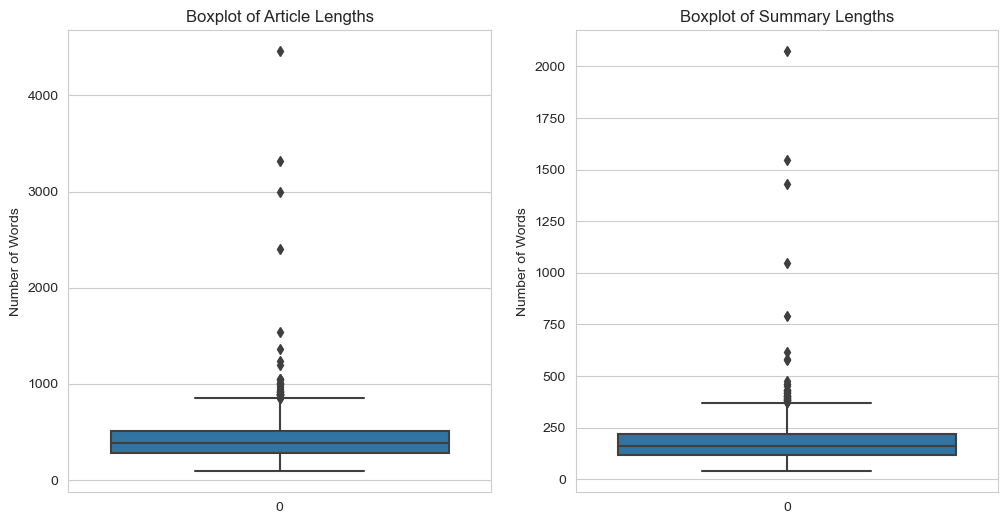

In [11]:
# Boxplots for Article and Summary Lengths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")

In [12]:
print(training_dataset.describe())

,article_length,summary_length
count,1328.000000,1328.000000
mean,421.438253,179.762048
std,242.685544,110.777280
min,90.000000,38.000000
25%,280.750000,118.000000
50%,380.000000,161.000000
75%,508.250000,219.000000
max,4460.000000,2073.000000


In [13]:
# Get statistics for the articles boxplot
lines_articles = axes[0].lines[:6]
articles_stats = [line.get_ydata()[0] for line in lines_articles]
Q1_articles, Q3_articles, lower_whisker_articles, upper_whisker_articles, median_articles = articles_stats[:5]

# Get statistics for the summaries boxplot
lines_summaries = axes[1].lines[:6]
summaries_stats = [line.get_ydata()[0] for line in lines_summaries]
Q1_summaries, Q3_summaries, lower_whisker_summaries, upper_whisker_summaries, median_summaries = summaries_stats[:5]

In [ ]:
def getUpperWhiskers(description):
    Q1 = description["25%"]
    Q3 = description["75%"]
    IQR = Q3-Q1
    upperWhisker = int(Q3+1.5*IQR)
    return upperWhisker

upper_whisker_articles = getUpperWhiskers(training_dataset.describe()['article_length'])
upper_whisker_summaries = getUpperWhiskers(training_dataset.describe()['summary_length'])


In [14]:
print(upper_whisker_articles)
print(upper_whisker_summaries)

849.0
369.0


In [15]:
training_dataset = training_dataset[(training_dataset['summary_length'] <= upper_whisker_summaries) & (training_dataset['article_length'] <= upper_whisker_articles)]
testing_dataset = testing_dataset[(testing_dataset['summary_length'] <= upper_whisker_summaries) & (testing_dataset['article_length'] <= upper_whisker_articles)]

Text(0.5, 1.0, 'Boxplot of Summary Lengths')

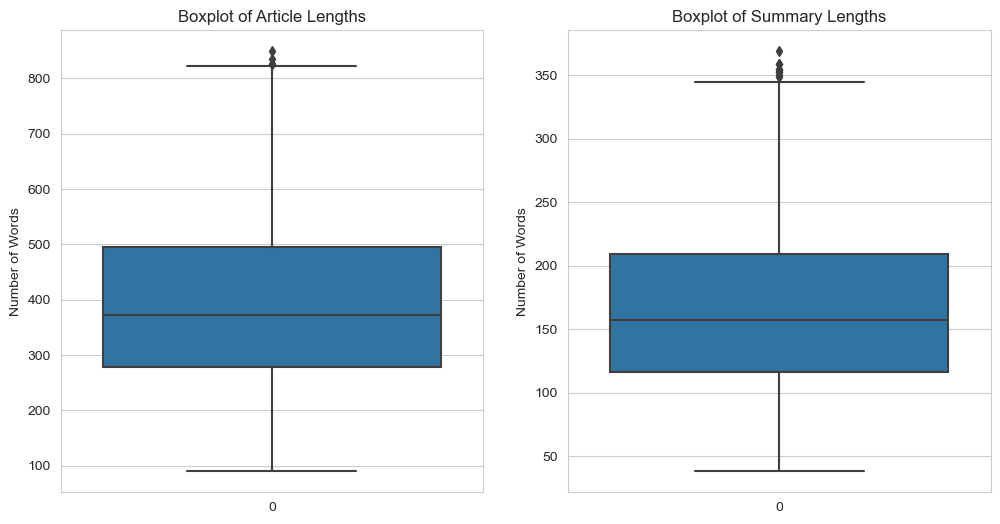

In [16]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the articles' number of words
sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

# Plot for the summaries' number of words
sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")


In [17]:
print(training_dataset.head())

,filename,newsarticle,summary,article_length,summary_length
0,tech_186,China blocks Google news site\n\nChina has bee...,"""China is censoring Google News to force inter...",349,158
1,politics_371,Howard pitches for UK ethnic vote\n\nMichael H...,"""So I say to all those people from ethnic mino...",377,158
2,business_498,Millions go missing at China bank\n\nTwo senio...,The other is China Construction Bank.The lates...,479,176
3,business_239,UK homes hit £3.3 trillion total\n\nThe value ...,More than a third of the UK's private housing ...,239,111
5,politics_395,Blair ready to call election\n\nTony Blair see...,And it looked like the Labour campaign - which...,509,230


In [18]:
print(training_dataset.describe())

,article_length,summary_length
count,1281.000000,1281.000000
mean,394.962529,167.705699
std,151.600885,66.488051
min,90.000000,38.000000
25%,278.000000,116.000000
50%,372.000000,157.000000
75%,496.000000,209.000000
max,849.000000,369.000000


In [19]:
# df = training_dataset[0:100]
df = training_dataset

In [20]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

In [21]:
# Define the device for GPU usage (if available)
if torch.backends.mps.is_available():
    arch = "mps"
elif torch.cuda.is_available():
    arch = "cuda"
else:
    arch = "cpu"

device = torch.device(arch)
# device = torch.device("cpu")

In [22]:
# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU

def tokenize_and_stack(df, text_column, summary_column):
    df['TokenizedText'] = df[text_column].apply(tokenize_text)
    df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)
    
    # Convert tokenized data to PyTorch tensors
    X = torch.stack([seq.squeeze() for seq in df['TokenizedText']])
    Y = torch.stack([seq.squeeze() for seq in df['TokenizedSummary']])
    
    # Define a DataLoader for batching data
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    return X, Y, dataloader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = testing_dataset[0:len(val_df)]

# Tokenize and stack for training set
X_train, Y_train, train_dataloader = tokenize_and_stack(train_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_val, Y_val, val_dataloader = tokenize_and_stack(val_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_test, Y_test, test_dataloader = tokenize_and_stack(test_df, 'newsarticle', 'summary')


/var/folders/qd/t1dpxdpn0xj2byx5h2wvvzr80000gn/T/ipykernel_33797/3102345579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TokenizedText'] = df[text_column].apply(tokenize_text)
/var/folders/qd/t1dpxdpn0xj2byx5h2wvvzr80000gn/T/ipykernel_33797/3102345579.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)


In [23]:
def genSummaryAndEvaluate(model, dataloader):
    model.eval()
    
    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []
    bert_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            max_length=280
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=280, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                target_text = ' '.join(target_text.split()[:max_length])
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)
                                                
                # # BERTScore
                _, _, bert_score_f1 = bert_score([output_text], [target_text], lang='en', model_type='bert-base-uncased')
                bert_scores.append(bert_score_f1.item())
                
                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    data = {
        'Article': test_articles,
        'Actual Summary': actual_summaries,
        'Predicted Summary': predicted_summaries,
        'ROUGE-1 Precision': rouge1_precision_scores,
        'BERT Score': bert_scores,

    }
    results_df = pd.DataFrame(data)
    return results_df
    # return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores


In [24]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
model.to(device)  # Move the model to the GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler

# Define gradient accumulation steps
accumulation_steps = 40  # You can adjust this number

/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:124: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [25]:
# Training loop
train_losses = []
rouge_scores = []
bert_scores = []
for epoch in range(3):  # Change the number of epochs as needed
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{2}")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    train_loss = total_loss / len(train_dataloader)
    train_losses.append(train_loss)
    evalResult = genSummaryAndEvaluate(model,val_dataloader)
    rouge = evalResult['ROUGE-1 Precision']
    bert = evalResult['BERT Score']
    rouge_scores.append(rouge.mean())
    bert_scores.append(bert.mean())
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}, Mean Evaluation Rouge-1 Score: {rouge.mean()}, Mean Evaluation BERT Score: {bert.mean()}")

sameCategoryData = evalResult

# Save the model after training
model.save_pretrained("KYS_BART_BASE")

Epoch 1/2:   0%|          | 0/256 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Evaluating Test: 100%|██████████| 65/65 [1:34:59<00:00, 87.69s/it]


Epoch 1/2, Train Loss: 0.3069, Mean Evaluation Rouge-1 Score: 0.6783181283114024, Mean Evaluation BERT Score: 0.7169286935709793


Evaluating Test: 100%|██████████| 65/65 [1:34:28<00:00, 87.21s/it]


Epoch 2/2, Train Loss: 0.3063, Mean Evaluation Rouge-1 Score: 0.6783181283114024, Mean Evaluation BERT Score: 0.7169286935709793


Evaluating Test: 100%|██████████| 65/65 [1:32:30<00:00, 85.39s/it]


Epoch 3/2, Train Loss: 0.3066, Mean Evaluation Rouge-1 Score: 0.6783181283114024, Mean Evaluation BERT Score: 0.7169286935709793


In [26]:
print(train_losses)

[0.30689444608287886, 0.30633647163631395, 0.30658191884867847]

In [27]:
print(rouge_scores)

[0.6783181283114024, 0.6783181283114024, 0.6783181283114024]

In [28]:
print(bert_scores)

[0.7169286935709793, 0.7169286935709793, 0.7169286935709793]

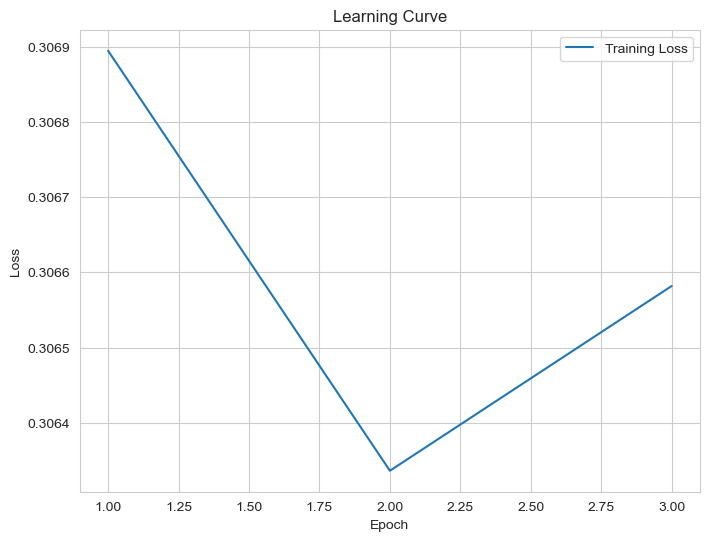

In [29]:
# Plot the Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

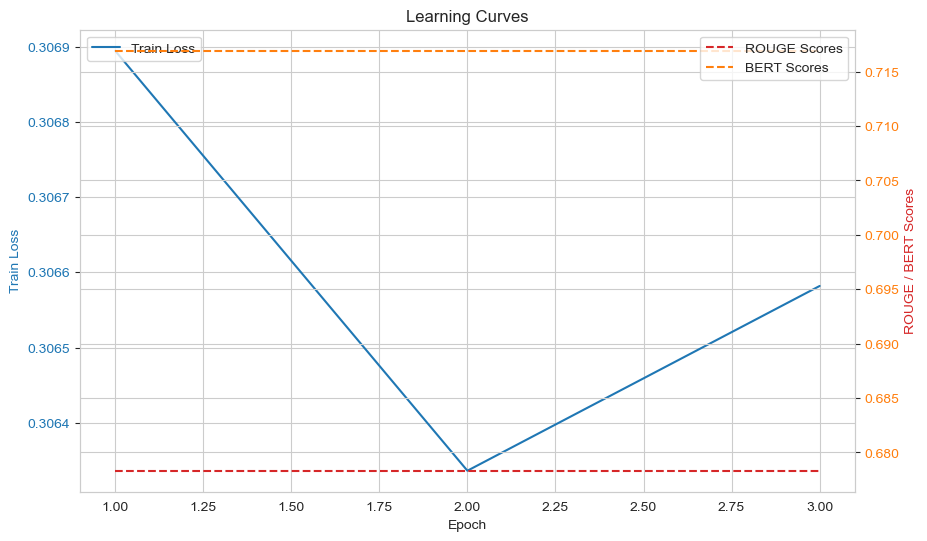

In [30]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)

# train_losses = [0.30070960372686384, 0.30086159333586693, 0.30086159333586693, 0.30086159333586693]
# 
# rouge_scores = [0.8, 0.85, 0.88, 0.92]  # Replace with your actual ROUGE scores
# bert_scores = [0.75, 0.78, 0.82, 0.86]   # Replace with your actual BERT scores
epochs = list(range(1, len(train_losses) + 1))
# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot train losses on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(epochs, train_losses, color='tab:blue', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for ROUGE and BERT scores
ax2 = ax1.twinx()
ax2.set_ylabel('ROUGE / BERT Scores', color='tab:red')

# Plot ROUGE scores on the second y-axis
ax2.plot(epochs, rouge_scores, color='tab:red', linestyle='dashed', label='ROUGE Scores')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot BERT scores on the second y-axis
ax2.plot(epochs, bert_scores, color='tab:orange', linestyle='dashed', label='BERT Scores')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legend
ax2.legend(loc='upper right')

# Show the plot
plt.title('Learning Curves')
plt.show()


sameCategoryData = genSummaryAndEvaluate(model,val_dataloader)

In [31]:
sameCategoryData[['ROUGE-1 Precision','BERT Score']]

,ROUGE-1 Precision,BERT Score
0,0.568075,0.654173
1,0.740964,0.736176
2,0.709302,0.737209
3,0.620155,0.655220
4,0.714286,0.723136
...,...,...
252,0.693548,0.701956
253,0.604839,0.693119
254,0.663677,0.718265
255,0.677419,0.743609


In [32]:
print(sameCategoryData['ROUGE-1 Precision'].mean(),sameCategoryData['BERT Score'].mean())

0.6783181283114024 0.7169286935709793


In [33]:
diffCategoryData = genSummaryAndEvaluate(model,test_dataloader)

Evaluating Test: 100%|██████████| 65/65 [1:30:33<00:00, 83.60s/it]


In [34]:
diffCategoryData[['ROUGE-1 Precision','BERT Score']]

,ROUGE-1 Precision,BERT Score
0,0.722222,0.648202
1,0.695652,0.641712
2,0.698565,0.742868
3,0.948454,0.746465
4,0.862319,0.737246
...,...,...
252,0.507614,0.670737
253,0.637037,0.683772
254,0.917647,0.691377
255,0.964912,0.758553


In [35]:
print(diffCategoryData['ROUGE-1 Precision'].mean(),diffCategoryData['BERT Score'].mean())

0.7139418105622555 0.6985639312851754


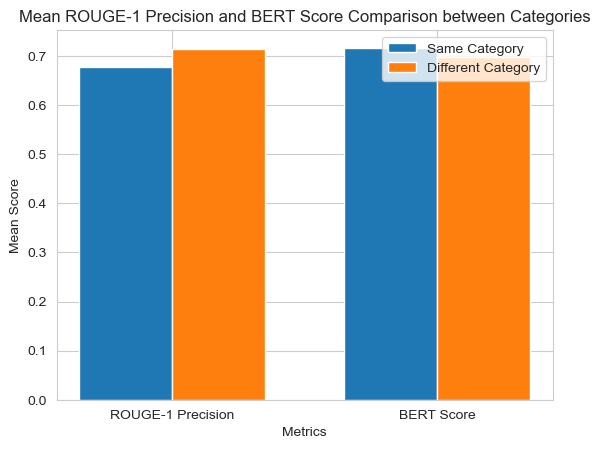

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_mean_rouge1 = sameCategoryData['ROUGE-1 Precision'].mean()
same_category_mean_bert = sameCategoryData['BERT Score'].mean()

diff_category_mean_rouge1 = diffCategoryData['ROUGE-1 Precision'].mean()
diff_category_mean_bert = diffCategoryData['BERT Score'].mean()

categories = ['ROUGE-1 Precision', 'BERT Score']
mean_scores_same_category = [same_category_mean_rouge1, same_category_mean_bert]
mean_scores_diff_category = [diff_category_mean_rouge1, diff_category_mean_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, mean_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, mean_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Score')
ax.set_title('Mean ROUGE-1 Precision and BERT Score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()


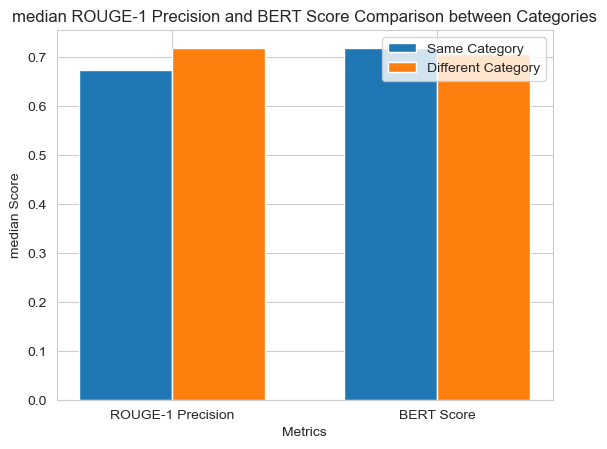

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_median_rouge1 = sameCategoryData['ROUGE-1 Precision'].median()
same_category_median_bert = sameCategoryData['BERT Score'].median()

diff_category_median_rouge1 = diffCategoryData['ROUGE-1 Precision'].median()
diff_category_median_bert = diffCategoryData['BERT Score'].median()

categories = ['ROUGE-1 Precision', 'BERT Score']
median_scores_same_category = [same_category_median_rouge1, same_category_median_bert]
median_scores_diff_category = [diff_category_median_rouge1, diff_category_median_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, median_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, median_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('median Score')
ax.set_title('median ROUGE-1 Precision and BERT Score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()

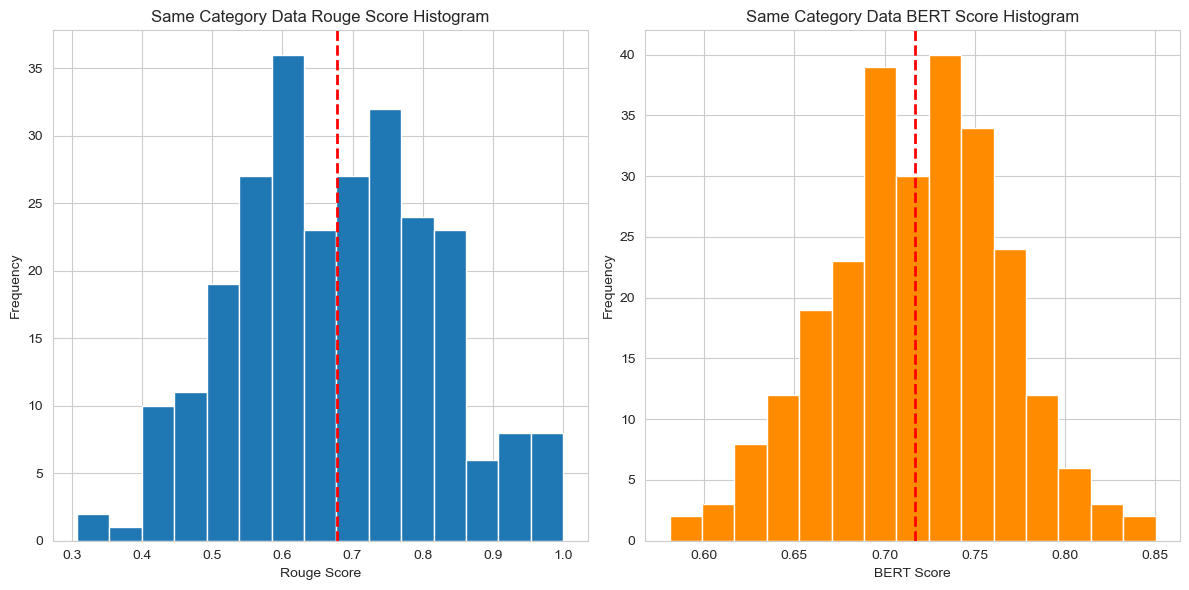

In [38]:
import matplotlib.pyplot as plt

# Calculate mean values
sameCat_mean_rouge = np.mean(sameCategoryData['ROUGE-1 Precision'])
sameCat_mean_bert = np.mean(sameCategoryData['BERT Score'])


# Create separate histogram plots for Rouge and BERT Scores
plt.figure(figsize=(12, 6))
# plt.title('Same Category Data')

# Rouge Score Histogram
plt.subplot(1, 2, 1)
plt.hist(sameCategoryData['ROUGE-1 Precision'], bins=15, color='#1f77b4')
plt.axvline(sameCat_mean_rouge, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_rouge:.3f}')
plt.title('Same Category Data Rouge Score Histogram')
plt.xlabel('Rouge Score')
plt.ylabel('Frequency')

# BERT Score Histogram
plt.subplot(1, 2, 2)
plt.hist(sameCategoryData['BERT Score'], bins=15, color='darkorange')
plt.axvline(sameCat_mean_bert, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {sameCat_mean_bert:.3f}')
plt.title('Same Category Data BERT Score Histogram')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [40]:
def generate_summary(model, text, max_length=280, num_beams=17, length_penalty=2.0, early_stopping=False):
    model.eval()
    
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)['input_ids'].to(device)
    
    # Generate summary
    with torch.no_grad():
        outputs = model.generate(input_ids=inputs, max_length=max_length, num_beams=num_beams, length_penalty=length_penalty, early_stopping=early_stopping)
    
    # Decode the generated summary
    summary_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return summary_text

# Example usage:
text_to_summarize = testing_dataset['newsarticle'][43]

summary = generate_summary(model, text_to_summarize)
# print(f"Text:\n{text_to_summarize}")
print(f"Summary:\n{summary}")

Summary:
Blues slam Blackburn over Savage bidBirmingham have confirmed Blackburn made a bid for Robbie Savage - but managing director Karen Brady has called it "derisory". Blackburn have reportedly offered £500,000 up front for the Wales star, 30, with the fee rising to £2.2m. But Brady told The Sun the bid was "a waste of fax paper and my time". She added: "The way things are going all this could affect the relationship between the clubs. Theyve got into Robbies head. But he is not for sale." Savages future at Birmingham has been the source of speculation for several weeks, with some fans criticising his performances for the club earlier in the season. However, good displays against West Brom and Aston Villa have impressed Blues fans. "The crowd gave me a massive standing ovation when I came off on Saturday which was nice," he said. "It was fantastic even though I was criticised by a number of them in recent weeks and on Saturday it showed how much I mean to them. "Its not for me to s

In [41]:
get_ipython().system('jupyter nbconvert --to script BART-Base.ipynb')

[NbConvertApp] Converting notebook BART-Base.ipynb to script
[NbConvertApp] Writing 20697 bytes to BART-Base.py
